# Notebook for exploring Weights and Normalizations for GAMS

Notebook Created on May 5, 2020 Modified on: May 32, 2020 by AJF

**Purpose** The purpose of this notebook is to investigate the normalization and weights in the GAMS Data Assimilation (DAS) Code.

**Files** The file "DAS_2020May30_newWeight.gdx and "DAS_2020May29_newNorm.gdx" contains the most recent results of running the DAS code. Python scripts are functions to run the notebook. The excel file stores the history of the many runs to finally get a reasonable convergence. 

Generally this notebook contains two types of plots:
* 1) Plots for <font color='green'>  **normalized residual values** </font> where residuals are the difference between measurements and estimates (or prior from a surrogate model and estimate) for each variable and they are normalized by the standard deviation of the residuals. The residual plots include: 
    * 1.1 residual vs. estimate plot, 
    * 1.2 cumalitive distribution plot, 
    * 1.3 histogram and fitted normal distribution, 
    * 1.4 qq plot. 

* 2) Plots for <font color='blue'>  **consistency and accuracy** </font> where the measurement and estimate are directly compared. 

The <font color='red'>  **variables** </font> included in this notebook with the respective abbreviations include:

Crop Area (CA), Irrigated Area (IR), Rainfed Area (RF),  Crop Production (Prod or X), Subcrop Production (Subprod), Basin river discharge (R2), Groundwater Head (H), Groundwater Depletion (gwd), ET from Modis, ET from the surrogate reduced order model (ROM), change in soil moisture (dS), Recharge (W), ETf for each pixel, additional dischare gauges (R)

**Notes**:
  * Although statistically none of the variables fit a standard normal(mean=0, stdev=1) distribution, several visually look somewhat normal/gaussion.
  * The plots do not have a consistent color scheme, please look at the legend as a color in one plot may represent a different line in another plot.

# Big Picture Reminder

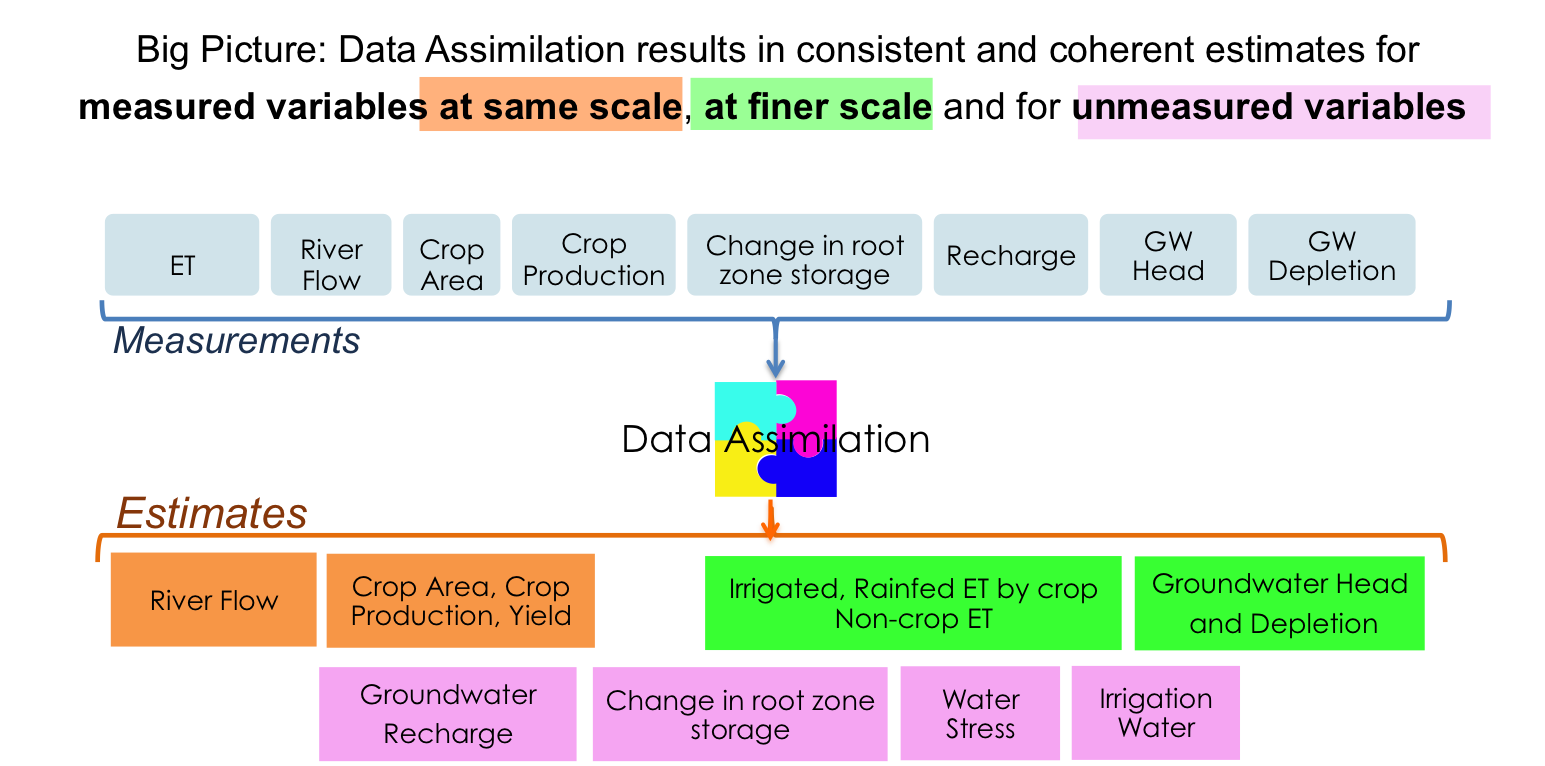

In [37]:
from IPython.display import Image
Image(filename="Figures/DAS_BigPicture.png", width=800, height=900)

Below is the objective with a short description of each part. Parts in double boxes are unmeasured but approximate with a model (redued order surrogate model of hydrus for water fluxes and FAO cropwat equation for subcrop production and yield).

# Optimization Objective

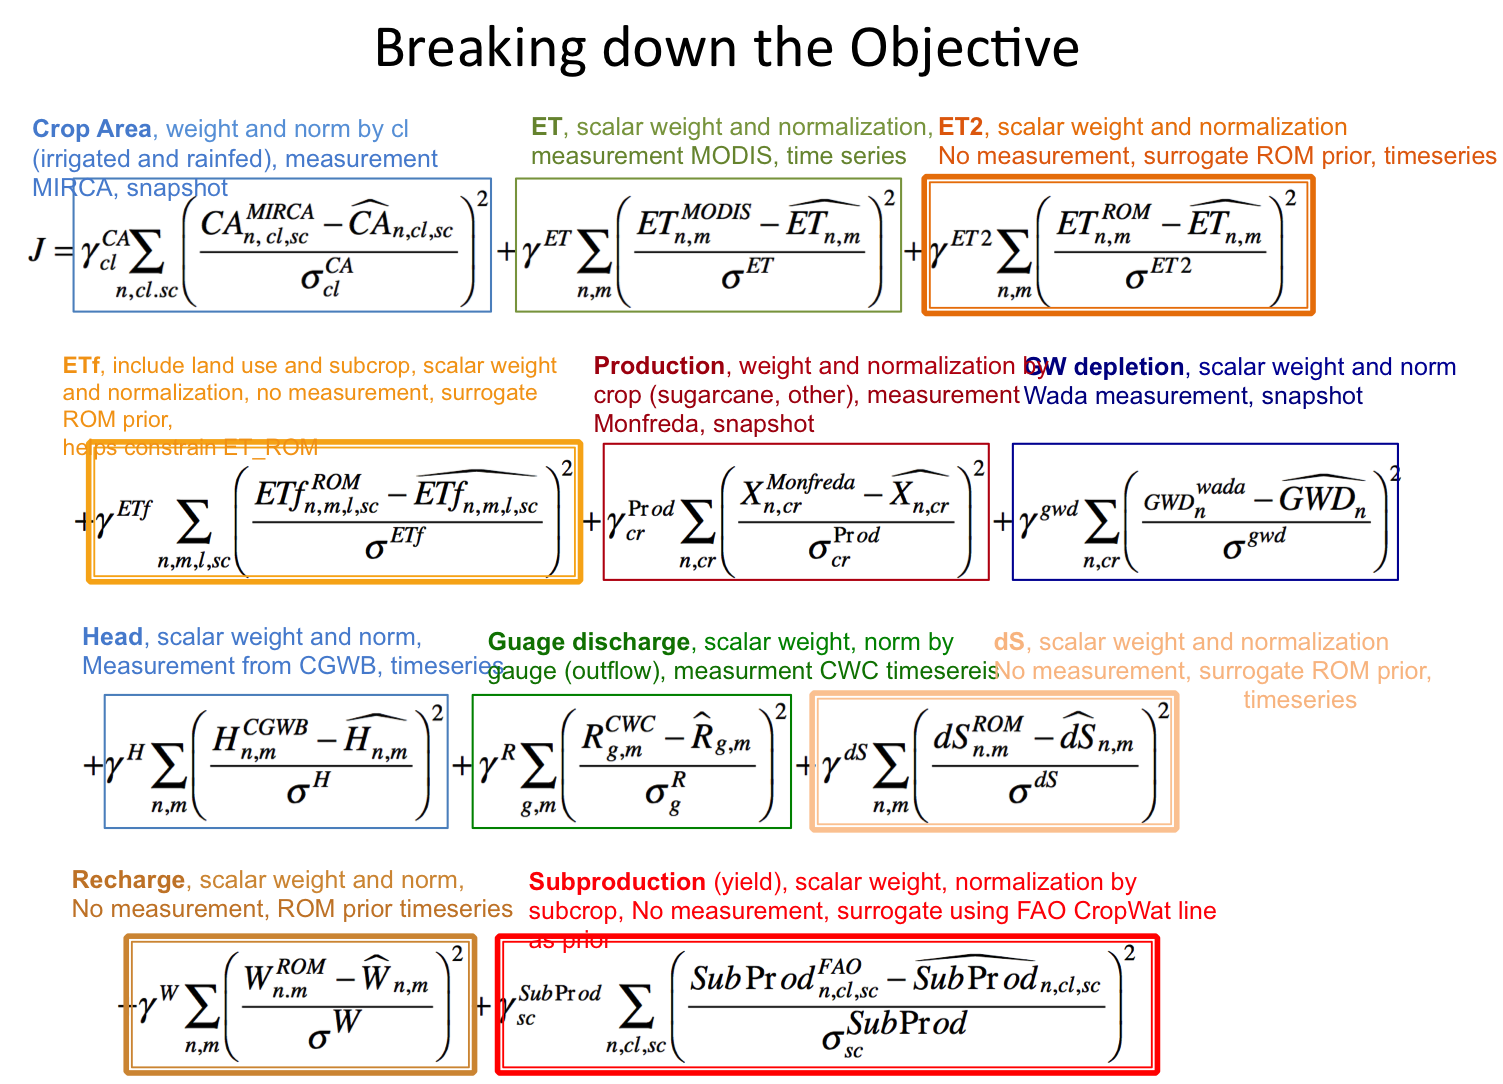

In [38]:
from IPython.display import Image
Image(filename="Figures/ObjectiveBrokenDown.png", width=800, height=900)

 <font color='red'>  Goal of this Analysis </font>: The goal is to determine the values of the normalization (sigma) and the weight (gamma). This notebook presents the results from last run where the weights "DAS_2020May30_newWeight.gdx"  were also varied but they did not make sufficient difference. It may be okay to go back to a weight of 1 (File "DAS_2020May29_newNorm.gdx"). 
 
**Subgoals** To decide that a normalization value was okay I checked: 1) means of residual close to zero, 2) standard deviation of residuals converging 3) consistency and accuracy tests were still reasonable. The table below summarizes the resulting values used in this run.


| Variable                  | Code | Weight |Normalization (res. stdev) |Units        |
|---------------------------|------|--------|---------------------------|-------------|
| Irrigated Area            | IR   | 3      |0.142                      |thousand km  |
| Rainfed Area              | RF   | 1      |0.340                      |thousand km  |
| Production                | X    | 1      |0.250                      |million tons |
| Sugarcane Production      | Xsgc | 2      |0.100                      |million tons |
| Runoff at various gauges  | R    | 1      |0.550                      |km3          |
| Runoff at basin outlet    | R2   | 1      |0.431                      |km3          |
| ET from Modis             | ET   | 1      |0.210                      |vol or depth |
| ET from ROM               | ET2  | 1      |0.230                      |vol or depth |
| Change in RZ Storage      | dS   | 1      |0.124                      |vol or depth |
| Recharge                  | W    | 1      |0.107                      |vol or depth |
| ETf                       | ETf  | 1      |0.090                      |vol or depth |
| GW Depletion              | gwd  | 1      |0.202                      |km3          |
| GW Heads                  | H    | 1      |0.060                      |km           |
| Subcrop Production        |      | 0.5    |0.880                      |million tons |
| Sugarcane Subcrop Prod.   |      | 0.5    |0.900                      |million tons |
| Sugarcane Other Annual    |      | 0.     |0.900                      |million tons |

**Compromises or adjustments** To achieve the goal,a few things were important, particularly for simplifying the objective:
* 1 – the form of the objective was important to avoid numerical difficulties in GAMS. I had to find the best equivalent form that seemed to have the least numerical issues. It’s shown above. It differs slightly from Dennis' notes only in that the number of observations are cancelled out. 
* 2 – For simplicity, I opted to try mostly scalar weights and all scalar normalizations with a few exceptions:
  * I did have to separate crop area into irrigated and rainfed. Irrigated crop area is still over estimated. 
  * I separated production into sugarcane vs. other crops. 
  * I used all the discharge gauges to inform the objective, but only really care about the fits at the basin end. I have different normalizations based on basin end gauge vs. other gauges. (Including all the gauges seems to help, but they don’t all match the measurment)
* 3 - I focused mostly on ensuring Basin discharge timeseries looked okay and that crop area was okay

**Process**
* 1-	Assumptions: to normalize residuals use standard deviation of residuals; For weights start with value of 1.
* 2-	As an initial guess start with standard deviation of data
* 3-	Run the code with the initial guess and replace the normalizations with the average between the old and new standard deviations
* 4-	Run again and check the following:
  * a.	Mean of residual (want close to 0)
  * b.	Standard deviation of residual (want to converge)
  * c.	Residual plot, distribution, QQ plot and CDF of residuals (want close to Gaussian?)
  * d.	Consistency plots (want measurement and data to be close)

Lots of things changing at same time.

# Plots Follow

# <font color='black'> Files and Functions </font>

In [39]:
# List Files to include
import os
import gdx

path = os.getcwd()
print(path)
file = []; 
#file.append("DAS_2020May29_newNorm.gdx");
file.append("GDXFiles/DAS_2020May30_newWeight.gdx");
runval = gdx.File(path+"/"+file[0], lazy=True, implicit=True, skip={}) 


/Users/Anjuli/GitHub/DAS_Tests


In [40]:
# Functions
%run 'PythonScripts/DAS_Krishna_Workflow_Functions.py'
%run 'PythonScripts/Norm_and_Weights.py'

In [41]:
from pandas import *
excelpath = 'ExcelFiles/TestingGAMSTemplate.xlsx'

xls = ExcelFile(excelpath)
df = xls.parse(xls.sheet_names[1], header=0)
row_num = df.set_index('var')['row_num'].to_dict()
#row_num

In [42]:
def write_to_excel(varname, rownum):
    #write to excel
    from openpyxl import load_workbook
    wb = load_workbook(filename = excelpath)
    sheet = wb.active
    num = str(row_num[varname])
    sheet["E"+num] = W*1
    sheet["F"+num] = norm*1
    sheet["G"+num] = resid_stdev
    sheet["H"+num] = resid_mean
    wb.save(filename=(excelpath))
    wb.close()

In [43]:
# Additional Function to test mean from normal distribution --> move this to python scripts later.
def do_two_sided_t_test(data):
    import scipy
    import numpy as np
    
    true_mean =0; 
    alpha = 0.05;
    
    t_stat, pvalue = scipy.stats.ttest_1samp(data, true_mean, axis=0, nan_policy='omit')#ignore nans
    
    print()
    print('T Test from scipy.stats')
    print('t_stat=%.3f'%t_stat)
    print('p-value=%.3e' %pvalue)
    
    if pvalue > alpha:
        print('(p>'+str(alpha)+') Accept null hypothesis that the mean is equal to ' + str(true_mean) +'from normal distrn')
        test = True
    else:
        print('(p<'+str(alpha)+') Reject the null hypothesis that the means is equal to '+ str(true_mean) +'from normal distrn')
        test = False
    
    
    x = np.linspace(min(data), max(data), 100)
    y1 = scipy.stats.norm.pdf(x)
    y2 = scipy.stats.norm.pdf(x, loc= np.nanmean(data))
        
    return test

In [44]:
savepath = path +'/Figures/OutputFigures/Figure_'
print(savepath)

/Users/Anjuli/GitHub/DAS_Tests/Figures/OutputFigures/Figure_


# <font color='black'> Residual Check and Data Comparisons </font>

## <font color='red'> Crop Area </font>

### <font color='green'> CA Resid </font>

Residual Stats
CA
mean=-0.005
stdv=0.143

Normality Test from scipy.stats
Statistics=13180.770, p=0.000
Sample does not look Gaussian (p<0.05)

T Test from scipy.stats
t_stat=-3.431
p-value=6.038e-04
(p<0.05) Reject the null hypothesis that the means is equal to 0from normal distrn


False

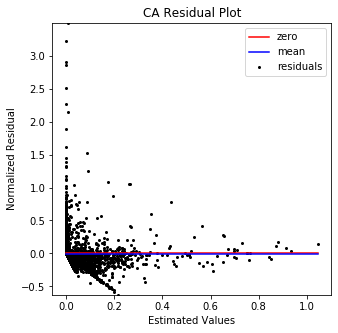

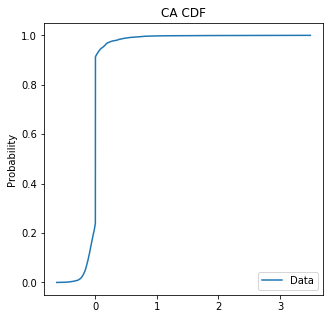

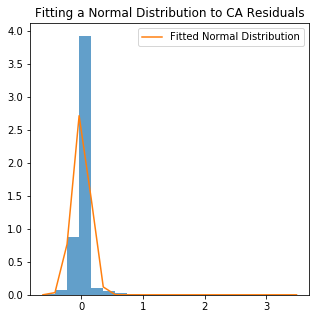

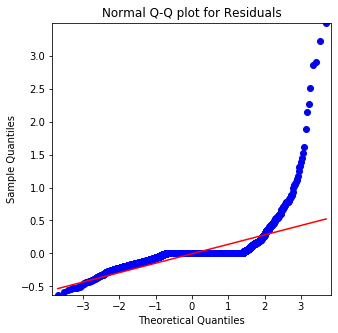

In [45]:
varname = 'CA'
savepath = path +'/Figures/OutputFigures/'+varname+"_"

# Store in DataFrames with Locations and Time index
res = ToDF(runval.misfitCA)
dat = ToDF(runval.CA_Data2*1e-3) #thousand km
mod = ToDF(runval.CA_Modeled)

resid_mean, resid_stdev, norm_residual, data, fits = residual_checks(varname, res,dat,mod, savepath)

do_two_sided_t_test(norm_residual)

### <font color='green'> IRA Resid </font>

Residual Stats
IR
mean=-0.027
stdv=0.100

Normality Test from scipy.stats
Statistics=8350.014, p=0.000
Sample does not look Gaussian (p<0.05)
norm=0.142
weight=1.000

T Test from scipy.stats
t_stat=-18.079
p-value=1.359e-70
(p<0.05) Reject the null hypothesis that the means is equal to 0from normal distrn


False

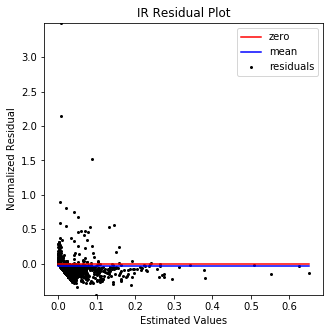

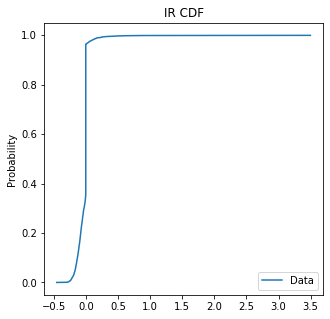

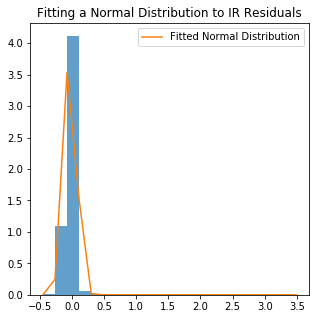

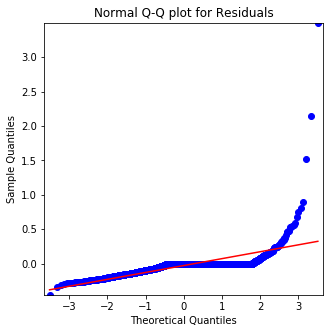

In [46]:
res = ToDF(runval.misfitCA)
dat = ToDF(runval.CA_Data2*1e-3) #thousand km
mod = ToDF(runval.CA_Modeled)

varname = 'IR'
savepath = path +'/Figures/OutputFigures/'+varname+"_"

ira_dat = dat.loc(axis=0)[:, :, 'ir',:]
ira_mod = mod.loc(axis=0)[:, :, 'ir',:]
ira_res = res.loc(axis=0)[:, :, 'ir',:]

norm = ToDF(runval.CA_norm2).loc(axis=0)['ir']['CA_norm2']   # normalization value
#W = runval.W_CA.data*1
W=1;

resid_mean, resid_stdev, norm_residual, data, fits = residual_checks(varname, ira_res,ira_dat,ira_mod, savepath)

print('norm=%.3f'%norm)
print('weight=%.3f'%W)

write_to_excel(varname, row_num)

do_two_sided_t_test(norm_residual)

### <font color='green'> RFA Resid </font>

Residual Stats
RF
mean=0.025
stdv=0.215

Normality Test from scipy.stats
Statistics=3215.459, p=0.000
Sample does not look Gaussian (p<0.05)
norm=0.340

T Test from scipy.stats
t_stat=6.430
p-value=1.479e-10
(p<0.05) Reject the null hypothesis that the means is equal to 0from normal distrn


False

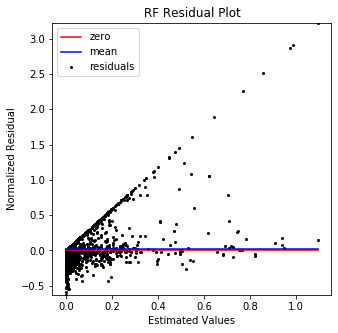

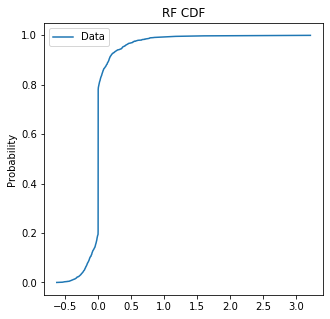

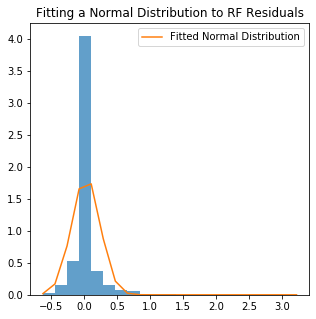

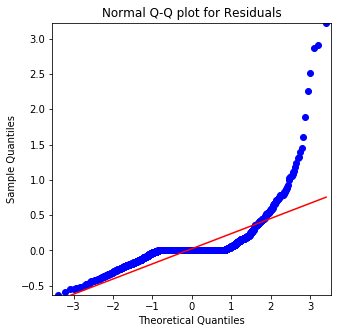

In [47]:
res = ToDF(runval.misfitCA)
dat = ToDF(runval.CA_Data2*1e-3) #thousand km
mod = ToDF(runval.CA_Modeled)


#--------------

varname = 'RF'
savepath = path +'/Figures/OutputFigures/'+varname+"_"

rfa_dat = dat.loc(axis=0)[:, :, 'rf',:]
rfa_mod = mod.loc(axis=0)[:, :, 'rf',:]
rfa_res = res.loc(axis=0)[:, :, 'rf',:]

norm = ToDF(runval.CA_norm2).loc(axis=0)['rf']['CA_norm2']     # normalization value

resid_mean, resid_stdev, norm_residual, data, fits = residual_checks(varname, rfa_res,dat,rfa_dat, savepath)

print('norm=%.3f'%norm)
#print('weight=%.3f'%W)

write_to_excel(varname, row_num)

do_two_sided_t_test(norm_residual)

### <font color='blue'> CA Bar Graph </font>

saved in /Users/Anjuli/GitHub/DAS_Tests/Figures/OutputFigures/RF_


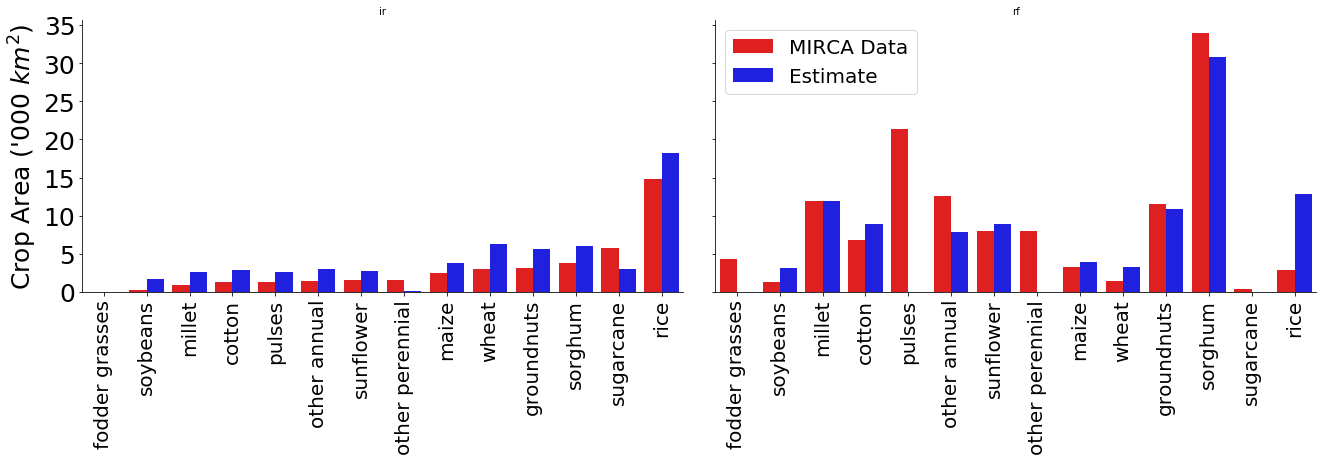

saved in /Users/Anjuli/GitHub/DAS_Tests/Figures/OutputFigures/CA_


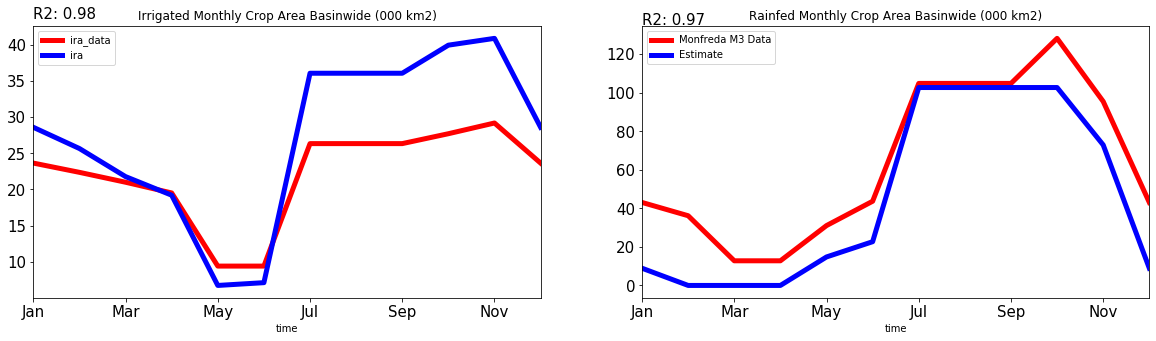

saved in /Users/Anjuli/GitHub/DAS_Tests/Figures/OutputFigures/CA_


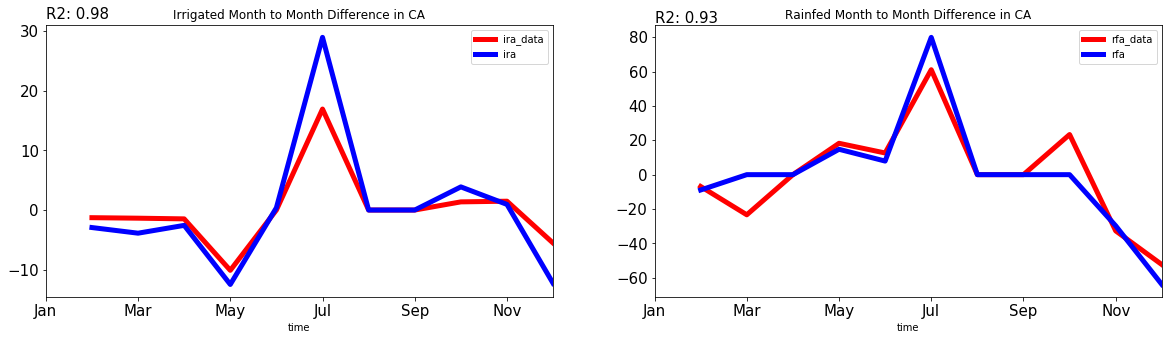

In [48]:
# Plots for Data
# Crop Area
CropAreaPlot(runval, savepath) #Function in Workflow Functions

input_data = gdx.File(os.getcwd()+"/"+"inputs.gdx")

ira_data= monthsort(ToDF(input_data.CA_Data[:,:,:,0,:]).groupby(level=['time']).sum(),0)*1e-3 #thousand m2
rfa_data= monthsort(ToDF(input_data.CA_Data[:,:,:,1,:]).groupby(level=['time']).sum(),0)*1e-3
ira_data.columns=['ira_data']
rfa_data.columns=['rfa_data']

# Function To Plot and Calculate
varname='CA'
savepath = path +'/Figures/OutputFigures/CA_'
CA_stats_corr, ira, rfa = LanduseTimeSeriesPlot (path,file,[], ira_data, rfa_data, savepath)


## <font color='red'> Production </font>

### <font color='green'> Prod Resid </font>

Residual Stats
Prod
mean=0.001
stdv=0.009

Normality Test from scipy.stats
Statistics=4031.102, p=0.000
Sample does not look Gaussian (p<0.05)
norm=0.250

T Test from scipy.stats
t_stat=5.813
p-value=6.910e-09
(p<0.05) Reject the null hypothesis that the means is equal to 0from normal distrn


False

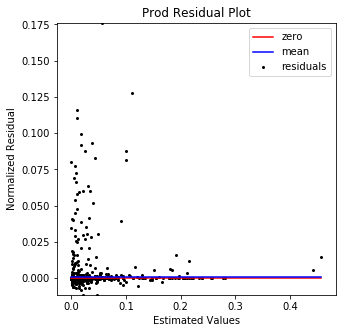

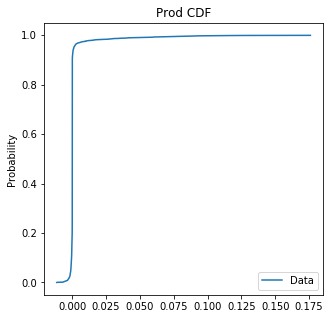

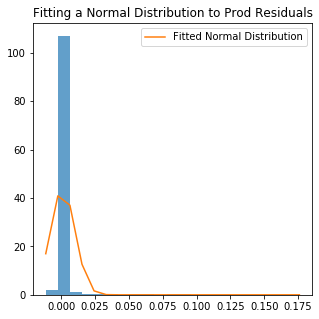

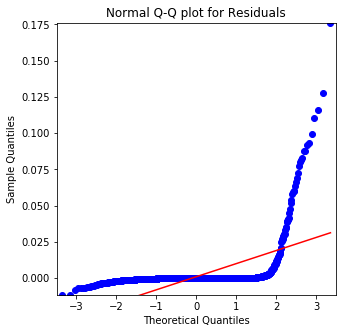

In [49]:
varname = 'Prod'
savepath = path +'/Figures/OutputFigures/Prod_'

# Store in DataFrames with Locations and Time index
res = ToDF(runval.misfitProd)
dat = ToDF(runval.Production_Data*1e-6)
mod = ToDF(runval.Production_Modeled)

allcrops = list(ToDF(runval.misfitProd).index.levels[2])
allcrops.remove('sugarcane')
allcrops

crs_dat = dat.loc(axis=0)[:, :, allcrops]
crs_mod = mod.loc(axis=0)[:, :, allcrops]
crs_res = res.loc(axis=0)[:, :, allcrops]

resid_mean, resid_stdev, norm_residual, data, fits= residual_checks(varname, crs_res,crs_dat,crs_mod, savepath)

norm = ToDF(runval.Production_norm2).loc(axis=0)['wheat']['Production_norm2']  # normalization value
W =1 # runval['W_Prod'].data          # weight

print('norm=%.3f'%norm)
#print('weight=%.3f'%W)

write_to_excel(varname, row_num)

do_two_sided_t_test(norm_residual)

### <font color='green'> Sugarcane Prod Resid </font>

Residual Stats
sugarcane
mean=0.632
stdv=2.346

Normality Test from scipy.stats
Statistics=313.880, p=0.000
Sample does not look Gaussian (p<0.05)
norm=0.100
weight=1.000

T Test from scipy.stats
t_stat=3.752
p-value=2.317e-04
(p<0.05) Reject the null hypothesis that the means is equal to 0from normal distrn


False

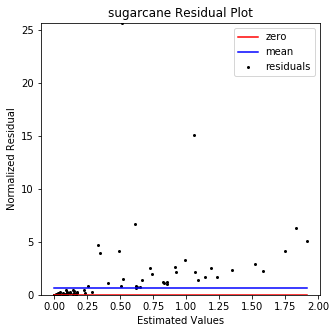

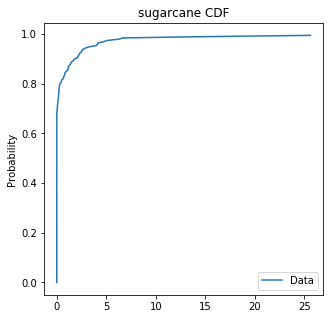

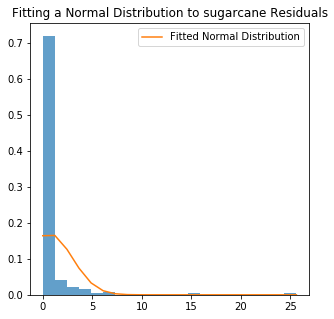

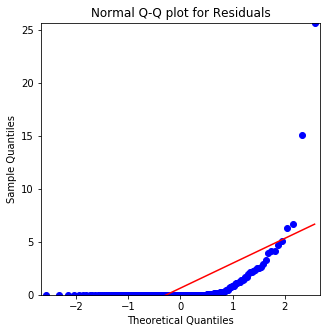

In [50]:
varname = 'sugarcane'
savepath = path +'/Figures/OutputFigures/'+varname+"_"

# Store in DataFrames with Locations and Time index
res = ToDF(runval.misfitProd)
dat = ToDF(runval.Production_Data*1e-6)
mod = ToDF(runval.Production_Modeled)

norm = ToDF(runval.Production_norm2).loc(axis=0)['sugarcane']['Production_norm2']

sgc_dat = dat.loc(axis=0)[:, :, 'sugarcane']
sgc_mod = mod.loc(axis=0)[:, :, 'sugarcane']
sgc_res = res.loc(axis=0)[:, :, 'sugarcane']

resid_mean, resid_stdev, norm_residual, data, fits = residual_checks(varname, sgc_res,sgc_dat,sgc_mod, savepath)

print('norm=%.3f'%norm)
print('weight=%.3f'%W)

write_to_excel(varname, row_num)

do_two_sided_t_test(norm_residual)

### <font color='blue'>Prod Bar Graph </font>

saved in /Users/Anjuli/GitHub/DAS_Tests/Figures/OutputFigures/sugarcane_


<Figure size 1080x360 with 0 Axes>

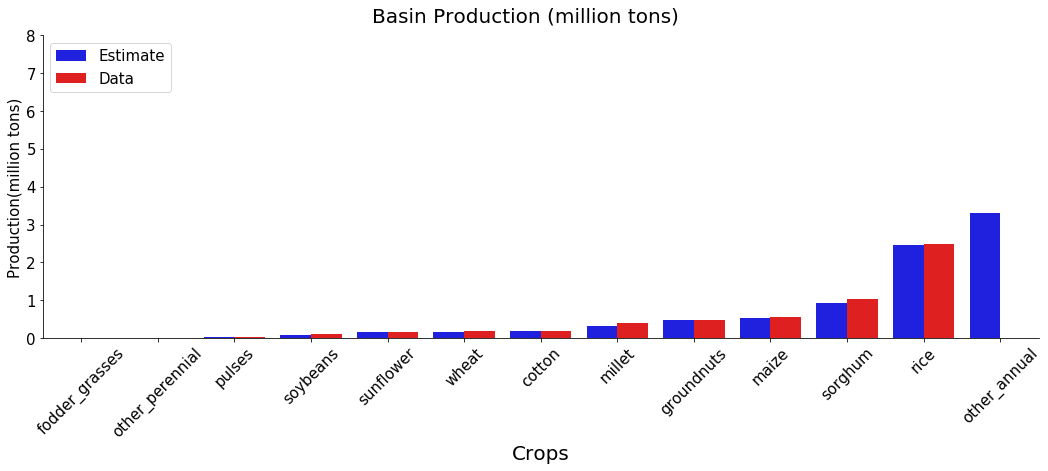

<Figure size 144x360 with 0 Axes>

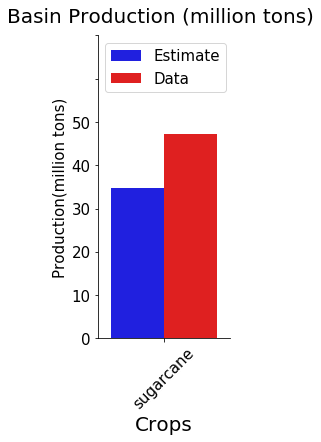

In [51]:
X  = plotProductionBar(path,file,runval, savepath)

SugarcaneX_ToPlot= X[X['crop']=='sugarcane']

plt.figure(figsize=(2, 5))
    
#axes_1 = plt.subplot(111)

import seaborn as sns
clrs = ['blue','red'] #['grey' if (x < max(values)) else 'red' for x in values ]


f = sns.catplot(data=SugarcaneX_ToPlot, x='crop', y='Production (million tons)',
                   hue='Label',  kind='bar', palette =clrs, #ax=axes_1,
                   height=10, aspect=1, legend=False, legend_out=True)

f.fig.set_size_inches(2,5)
f.fig.suptitle('Basin Production (million tons)', fontsize=20)
f.fig.subplots_adjust(top=.9) #leave space

f.set_xlabels('Crops', fontsize= 20)
f.set_xticklabels(rotation=45, fontsize=15)

f.set_ylabels('Production(million tons)', fontsize= 15)
f.set_yticklabels(fontsize=15, rotation=0)
f.set_titles(size=20)

plt.legend(loc='upper left', fontsize=15)

plt.ylim([0,70])

plt.show()

Sugarcane production is still too low. We had hoped to improve it. I think it's being pulled down by our FAO cropwat estimates. I tried to lower the weight for Subcrop production but maybe not enough.

## <font color='red'>SubProd Graph </font>

### <font color='green'> SubProd Resid </font>

Residual Stats
Subprod
mean=-0.003
stdv=0.050

Normality Test from scipy.stats
Statistics=20452.842, p=0.000
Sample does not look Gaussian (p<0.05)
norm=0.882
weight=0.500

T Test from scipy.stats
t_stat=-5.020
p-value=5.273e-07
(p<0.05) Reject the null hypothesis that the means is equal to 0from normal distrn


False

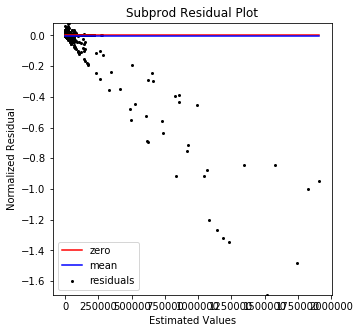

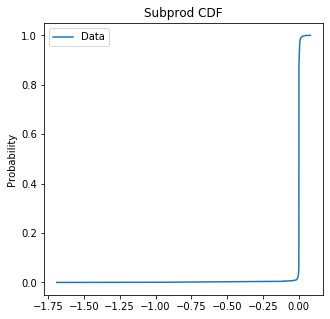

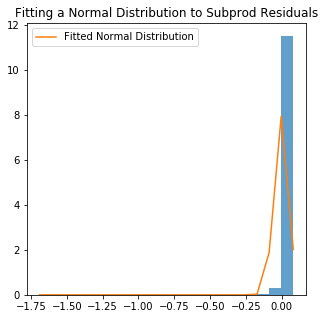

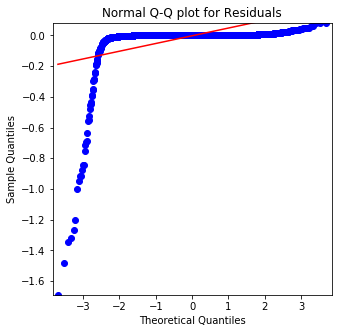

In [52]:
varname = 'Subprod'
savepath = path +'/Figures/OutputFigures/'+varname+"_"

res = ToDF(runval.misfitSubProd)
dat = ToDF(runval.SubcropProductionPrior*1e-6)
mod = ToDF(runval.SubcropProduction)

norm = runval['SubProd_norm2'].mean().data*1  # normalization value
W = runval['W_SubProd'].data          # weight

resid_mean, resid_stdev, norm_residual, data, fits = residual_checks(varname, res,dat,mod, savepath)

print('norm=%.3f'%norm)
print('weight=%.3f'%W)

write_to_excel(varname, row_num)

do_two_sided_t_test(norm_residual)

### <font color='blue'> SubProd Graph </font>

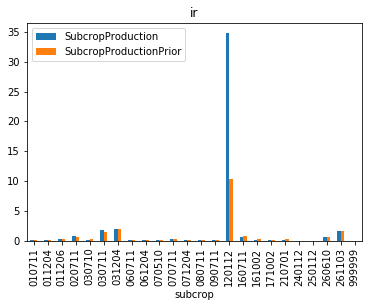

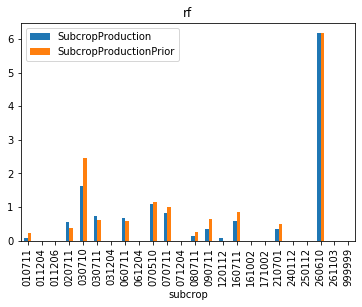

In [53]:
res = ToDF(runval.misfitSubProd)
dat = ToDF(runval.SubcropProductionPrior*1e-6)
mod = ToDF(runval.SubcropProduction*1e-6)

df1 = mod.groupby(['clut','subcrop']).sum()
df2 = dat.groupby(['clut','subcrop']).sum()
df3 = df1.join(df2)
df4 = df3.reset_index()

ir = (df4[df4['clut']=='ir']).set_index('subcrop').drop('clut', axis=1)
ir.plot(kind='bar', title='ir')

rf = (df4[df4['clut']=='rf']).set_index('subcrop').drop('clut', axis=1)
rf.plot(kind='bar', title='rf')

Subcrop production is based on our FAO cropwat equation. Sugarcane is code "120112". The FAO suggests to low a subcrop production compared to Monfreda. This may be pulling the sugarcane estimate down.

## <font color='red'> Basin Runoff </font>

### <font color='green'> Runoff (R2) Resid </font>

Residual Stats
R2
mean=0.978
stdv=0.893

Normality Test from scipy.stats
Statistics=3.422, p=0.181
Sample looks Gaussian (p>0.05)


/Users/Anjuli/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


norm=0.431
weight=1.000

T Test from scipy.stats
t_stat=3.635
p-value=3.924e-03
(p<0.05) Reject the null hypothesis that the means is equal to 0from normal distrn


False

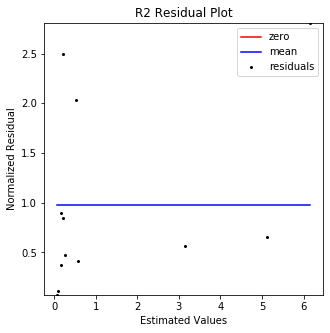

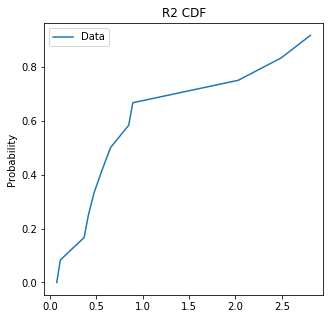

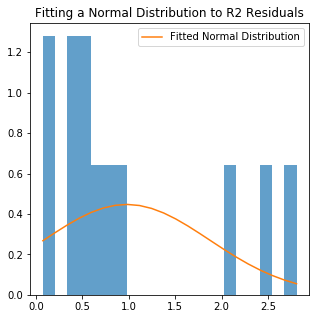

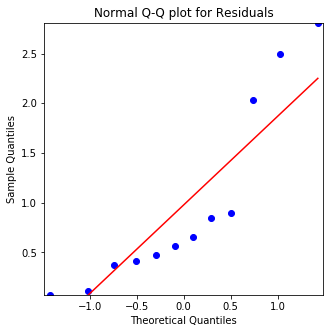

In [54]:
varname = 'R2'
savepath = path +'/Figures/OutputFigures/'+varname+"_"

res = ToDF(runval.misfitR)
dat = ToDF(runval.R_Data)
mod = ToDF(runval.R_Modeled)

res = res.loc(axis=0)['06','14',:]
dat = dat.loc(axis=0)['06','14',:]
mod = dat.loc(axis=0)['06','14',:]

norm = ToDF(runval.R_norm2).loc(axis=0)['06','14']['R_norm2']   # normalization value
W = 1; #runval['W_'+varname].data          # weight

resid_mean, resid_stdev, norm_residual, data, fits = residual_checks(varname, res,dat,mod, savepath)

print('norm=%.3f'%norm)
print('weight=%.3f'%W)

write_to_excel(varname, row_num)

do_two_sided_t_test(norm_residual)

### <font color='blue'> Runoff Timeseries </font>

saved in /Users/Anjuli/GitHub/DAS_Tests/Figures/OutputFigures/R2_


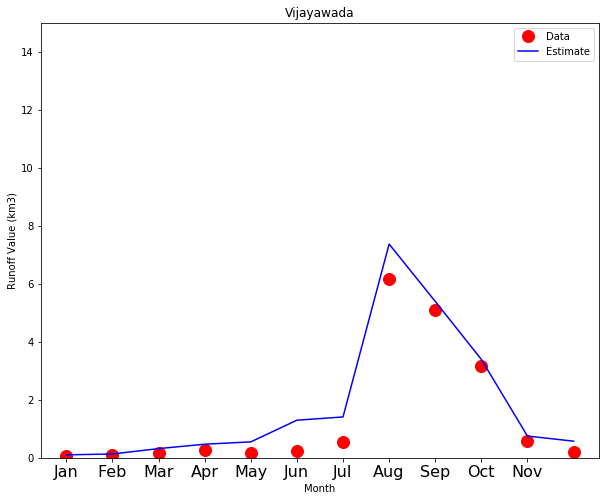

Pearsons correlation: 0.987
Spearman correlation: 0.930
DataSum: 16.698
ModSum: 21.757
0.3029861360697931


In [56]:
df = plotrunoff(runval, runval, savepath)


from scipy.stats import pearsonr, spearmanr

corr_p = pearsonr(df['R_Data'], df['R_Modeled'])
corr_s = spearmanr(df['R_Data'], df['R_Modeled'])

print('Pearsons correlation: %.3f' % corr_p[0])
print('Spearman correlation: %.3f' % corr_s[0])
print('DataSum: %.3f'% df['R_Data'].sum())
print('ModSum: %.3f' % df['R_Modeled'].sum())
print((df['R_Modeled'].sum() - df['R_Data'].sum())/df['R_Data'].sum())

Basin discharge fits okay. It's overestimating. Not sure why? I can get better fits adjusting the normalization but it affects other thing too.

## <font color='red'> GW Head </font>

### <font color='green'> Head Resid </font>

Residual Stats
H
mean=0.001
stdv=0.052

Normality Test from scipy.stats
Statistics=2649.294, p=0.000
Sample does not look Gaussian (p<0.05)
norm=0.060
weight=1.000

T Test from scipy.stats
t_stat=0.591
p-value=5.548e-01
(p>0.05) Accept null hypothesis that the mean is equal to 0from normal distrn


True

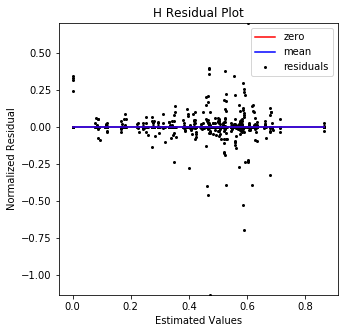

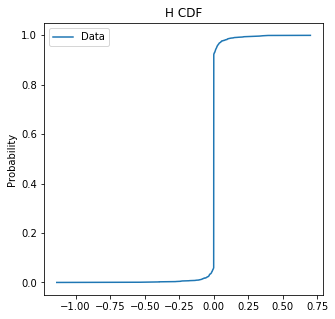

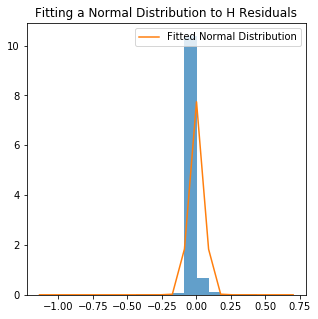

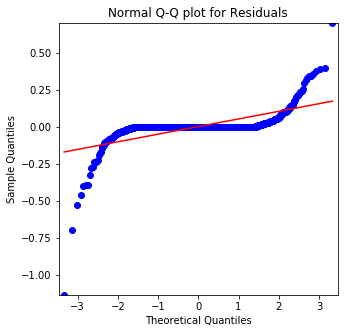

In [57]:
## Data
varname = 'H'
savepath = path +'/Figures/OutputFigures/'+varname+"_"
mTokm=1e-3


# Store in DataFrames with Locations and Time index
res = ToDF(runval.misfitH)
dat = ToDF(runval.Head_Data*mTokm)
mod = ToDF(runval.H)

norm = runval[varname+'_norm2'].data   # normalization value
W = runval['W_'+varname].data          # weight

resid_mean, resid_stdev, norm_residual, data, fits = residual_checks(varname, res,dat,mod, savepath)

print('norm=%.3f'%norm)
print('weight=%.3f'%W)

write_to_excel(varname, row_num)

do_two_sided_t_test(norm_residual)

### <font color='blue'> Head Scatter Fit </font>

saved in /Users/Anjuli/GitHub/DAS_Tests/Figures/OutputFigures/H_


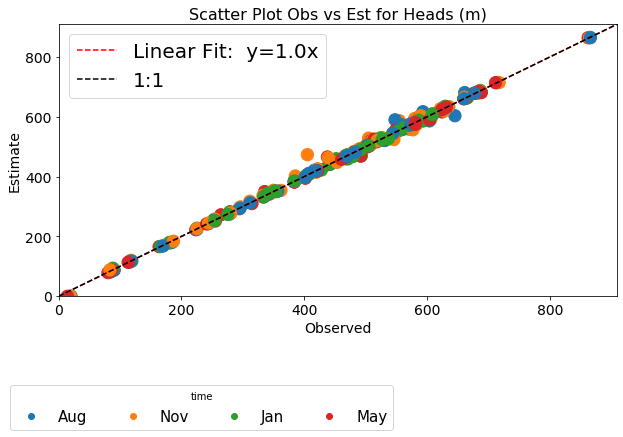

In [58]:
savepath = path +'/Figures/OutputFigures/H_'
stats = plotGWHeadScatter(runval,[], savepath)

Heads fit well, both in time and space.

saved in /Users/Anjuli/GitHub/DAS_Tests/Figures/OutputFigures/H_


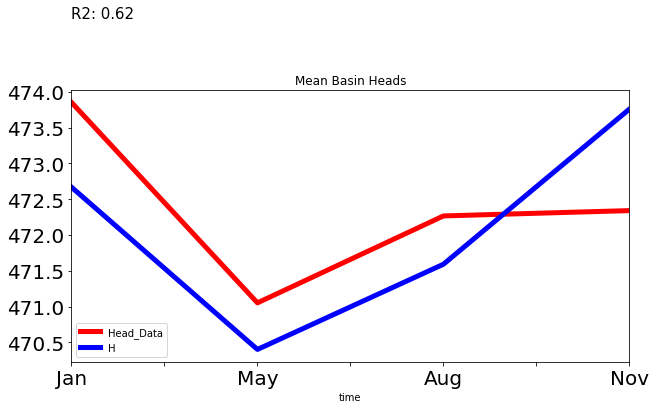

In [59]:
savepath = path +'/Figures/OutputFigures/H_'
df = plotMeanBasinHeadTS(runval,[], savepath)

## <font color='red'> GW Depletion </font>

### <font color='green'> GW Depletion Resid </font>

Residual Stats
GWD
mean=0.152
stdv=0.318

Normality Test from scipy.stats
Statistics=45.437, p=0.000
Sample does not look Gaussian (p<0.05)
norm=0.202
weight=1.000

T Test from scipy.stats
t_stat=4.422
p-value=2.846e-05
(p<0.05) Reject the null hypothesis that the means is equal to 0from normal distrn


False

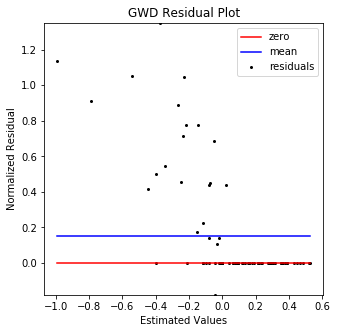

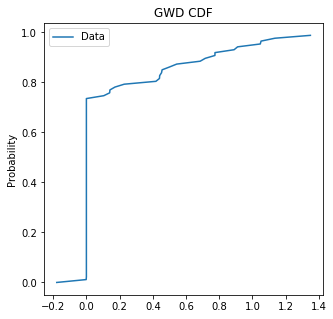

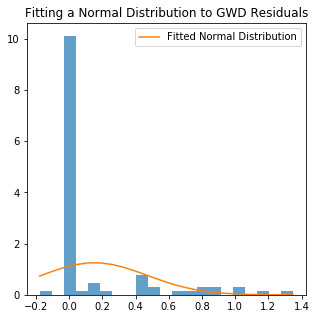

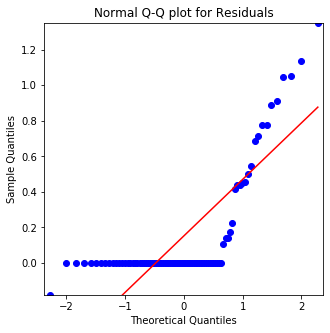

In [60]:
## Data
varname = 'GWD'
savepath = path +'/Figures/OutputFigures/'+varname+"_"
mTokm=1e-3


# Store in DataFrames with Locations and Time index
res = ToDF(runval.misfitGW)
dat = ToDF(runval.gwd)
mod = ToDF(runval.GWD_Modeled)
#pd.DataFrame((runval.SSy.data*runval.A.data*runval.m2Tokm2.data)*((runval.Hfinal.data)-runval.H[:,:,0].data)).unstack()

norm = runval['gwd_norm2'].data   # normalization value
W = runval['W_GWD'].data          # weight

resid_mean, resid_stdev, norm_residual, data, fits= residual_checks(varname, res,dat,mod, savepath)

print('norm=%.3f'%norm)
print('weight=%.3f'%W)

write_to_excel(varname, row_num)

do_two_sided_t_test(norm_residual)

### <font color='blue'> GW Depletion Scatter Fit </font>

saved in /Users/Anjuli/GitHub/DAS_Tests/Figures/OutputFigures/GWD_


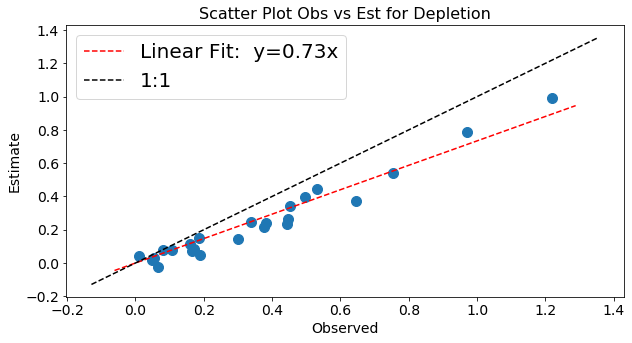

In [62]:
savepath = path +'/Figures/OutputFigures/GWD_'
df = plotGWDepletionScatter(runval, [], savepath)

## <font color='red'> ET, Soil Moisture, Recharge </font>

### <font color='green'> ET (MODIS) Resid </font>

Residual Stats
ET
mean=0.001
stdv=0.198

Normality Test from scipy.stats
Statistics=538.606, p=0.000
Sample does not look Gaussian (p<0.05)
norm=0.210
weight=1.000

T Test from scipy.stats
t_stat=0.346
p-value=7.293e-01
(p>0.05) Accept null hypothesis that the mean is equal to 0from normal distrn


True

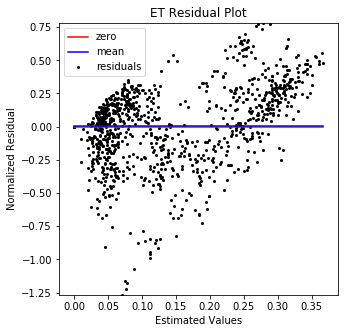

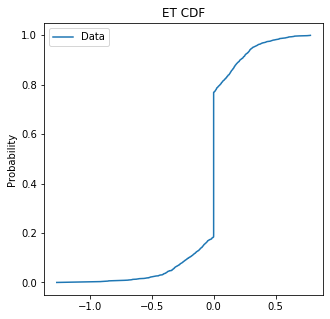

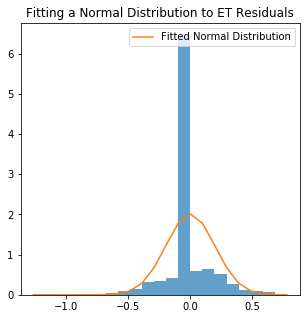

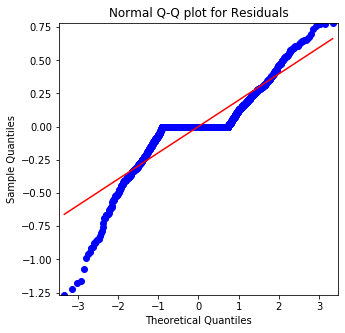

In [63]:
## Data
varname = 'ET'
savepath = path +'/Figures/OutputFigures/'+varname+"_"

# Store in DataFrames with Locations and Time index
res = ToDF(runval.misfitET)
dat = ToDF(runval.ET_Data)
mod = ToDF(runval.ET_Modeled)

resid_mean, resid_stdev, norm_residual, data, fits = residual_checks(varname, res,dat,mod, savepath)

norm = runval[varname+'_norm2'].data   # normalization value
W = runval['W_'+varname].data          # weight



print('norm=%.3f'%norm)
print('weight=%.3f'%W)

write_to_excel(varname, row_num)

do_two_sided_t_test(norm_residual)

### <font color='green'> ET2 (ROM) Resid </font>

Residual Stats
ET2
mean=0.105
stdv=0.218

Normality Test from scipy.stats
Statistics=1421.043, p=0.000
Sample does not look Gaussian (p<0.05)
norm=0.230
weight=1.000

T Test from scipy.stats
t_stat=23.190
p-value=2.931e-107
(p<0.05) Reject the null hypothesis that the means is equal to 0from normal distrn


False

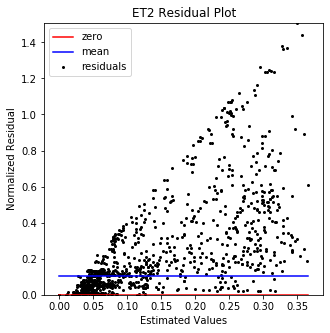

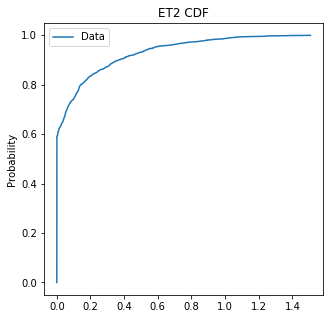

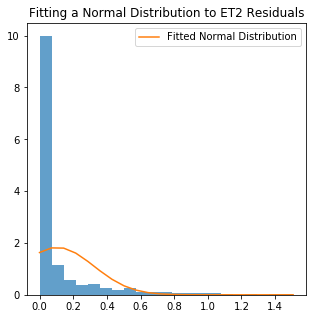

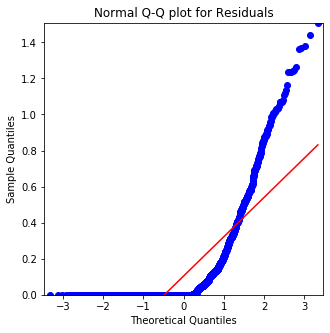

In [64]:
varname = 'ET2' #ROM
savepath = path +'/Figures/OutputFigures/'+varname+"_"

# Store in DataFrames with Locations and Time index
res = ToDF(runval.misfitET2)
dat = ToDF(runval.ET_ROM_pixel)
mod = ToDF(runval.ET_Modeled)

norm = runval[varname+'_norm2'].data   # normalization value
W = runval['W_'+varname].data          # weight

resid_mean, resid_stdev, norm_residual, data, fits = residual_checks(varname, res,dat,mod, savepath)

print('norm=%.3f'%norm)
print('weight=%.3f'%W)

write_to_excel(varname, row_num)

do_two_sided_t_test(norm_residual)

### <font color='green'> SM Resid </font>

Residual Stats
dS
mean=0.014
stdv=0.106

Normality Test from scipy.stats
Statistics=851.518, p=0.000
Sample does not look Gaussian (p<0.05)
norm=0.124
weight=1.000

T Test from scipy.stats
t_stat=6.270
p-value=4.297e-10
(p<0.05) Reject the null hypothesis that the means is equal to 0from normal distrn


False

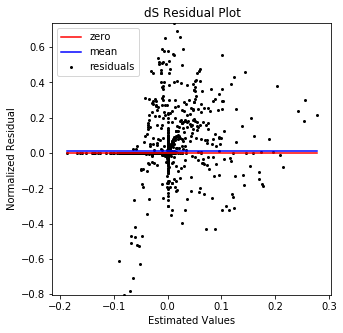

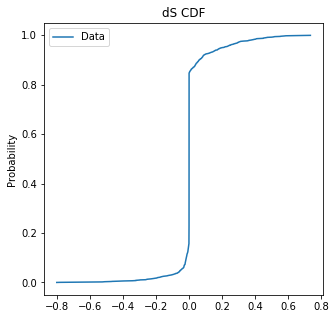

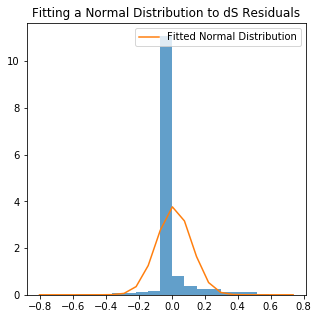

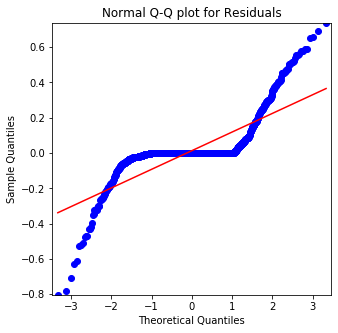

In [65]:
## Data
varname = 'dS'
savepath = path +'/Figures/OutputFigures/'+varname+"_"

# Store in DataFrames with Locations and Time index
res = ToDF(runval.misfitdS)
dat = ToDF(runval.dS_ROM_pixel)
mod = ToDF(runval.dS_Modeled)

norm = runval[varname+'_norm2'].data   # normalization value
W = runval['W_'+varname].data          # weight

resid_mean, resid_stdev, norm_residual, data, fits= residual_checks(varname, res,dat,mod, savepath)

print('norm=%.3f'%norm)
print('weight=%.3f'%W)

write_to_excel(varname, row_num)

do_two_sided_t_test(norm_residual)

### <font color='green'> Recharge Resid </font>

Residual Stats
W
mean=0.000
stdv=0.106

Normality Test from scipy.stats
Statistics=570.982, p=0.000
Sample does not look Gaussian (p<0.05)
norm=0.107
weight=1.000

T Test from scipy.stats
t_stat=0.005
p-value=9.958e-01
(p>0.05) Accept null hypothesis that the mean is equal to 0from normal distrn


True

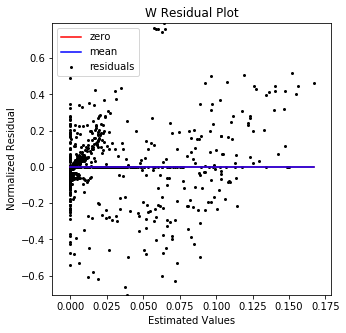

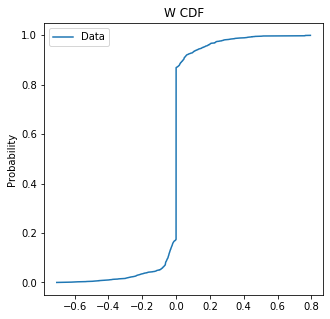

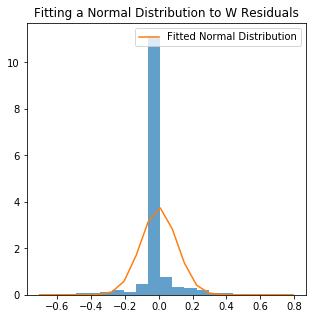

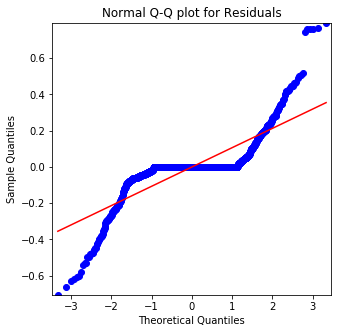

In [66]:
varname = 'W'
savepath = path +'/Figures/OutputFigures/'+varname+"_"

# Store in DataFrames with Locations and Time index
res = ToDF(runval.misfitW)
dat = ToDF(runval.W_ROM_pixel)
mod = ToDF(runval.W_Modeled)

norm = runval[varname+'_norm2'].data   # normalization value
W = runval['W_'+varname].data          # weight

resid_mean, resid_stdev, norm_residual, data, fits = residual_checks(varname, res,dat,mod, savepath)

print('norm=%.3f'%norm)
print('weight=%.3f'%W)

write_to_excel(varname, row_num)

do_two_sided_t_test(norm_residual)

### <font color='blue'> ET, SM, W Timeseries </font>

saved in /Users/Anjuli/GitHub/DAS_Tests/Figures/OutputFigures/ROM_


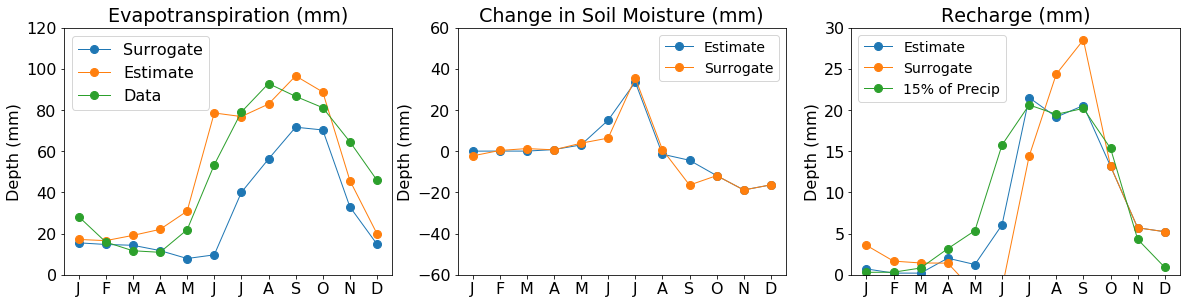

In [67]:
savepath = path +'/Figures/OutputFigures/ROM_'
ROM(runval, savepath)

This is not bad, the rechrge is closer the the order of 15% precip than previos runs. Change in Soil Moisture is similar. The biggest change is coming in ET (which is tied to the land use, particulalry irrigated). Also the surrogate model is now uch lower. We already suspected Modis to underestimate so I'm a little concerned that we may be givin it to much weight and that is pulling the estimate closer to the data.

## ETf and R gauges

### <font color='green'> ETf Resid </font>

Residual Stats
ETf
mean=0.001
stdv=0.135

Normality Test from scipy.stats
Statistics=286871.229, p=0.000
Sample does not look Gaussian (p<0.05)
norm=0.090
weight=1.000

T Test from scipy.stats
t_stat=3.497
p-value=4.705e-04
(p<0.05) Reject the null hypothesis that the means is equal to 0from normal distrn


False

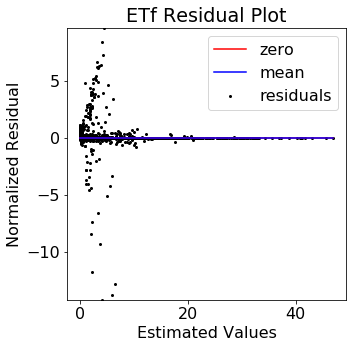

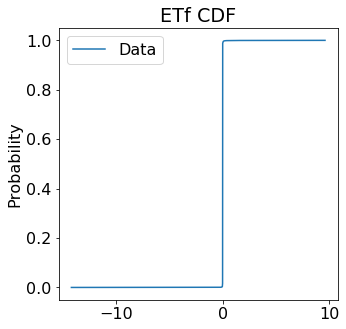

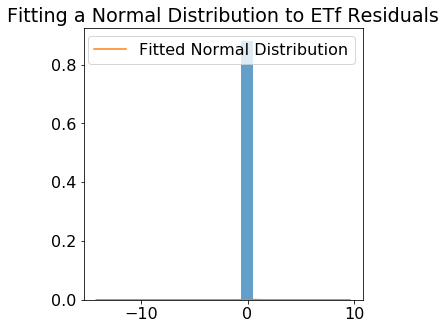

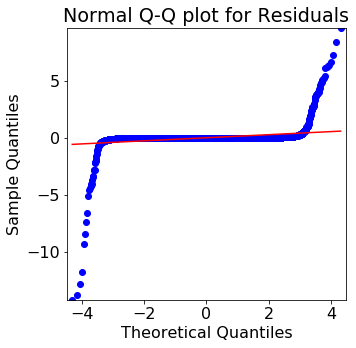

In [68]:
## Data
varname = 'ETf'
savepath = path +'/Figures/OutputFigures/'+varname+"_"

# Store in DataFrames with Locations and Time index
res = ToDF(runval.misfitETf)
dat = ToDF(runval.ETf)
mod = ToDF(runval.ETf_ROM)

norm = runval[varname+'_norm2'].data   # normalization value
W = runval['W_'+varname].data          # weight

resid_mean, resid_stdev, norm_residual, data, fits = residual_checks(varname, res,dat,mod, savepath)

print('norm=%.3f'%norm)
print('weight=%.3f'%W)

write_to_excel(varname, row_num)

do_two_sided_t_test(norm_residual)

### <font color='green'> R Gauges Resid </font>

Residual Stats
R
mean=-0.023
stdv=0.314

Normality Test from scipy.stats
Statistics=2981.440, p=0.000
Sample does not look Gaussian (p<0.05)
norm=0.550
weight=1.000

T Test from scipy.stats
t_stat=-3.005
p-value=2.692e-03
(p<0.05) Reject the null hypothesis that the means is equal to 0from normal distrn


False

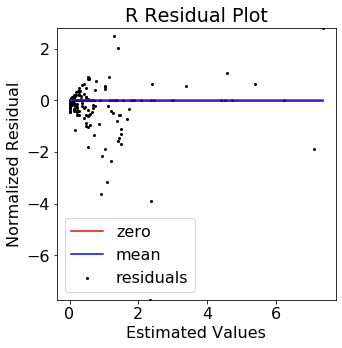

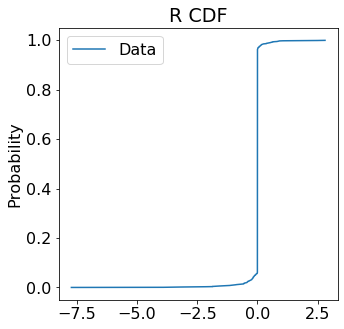

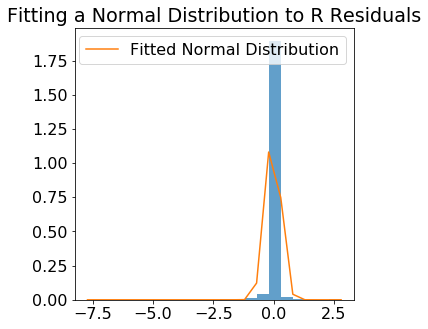

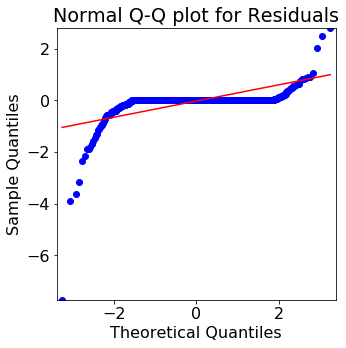

In [69]:
## Data
varname = 'R'
savepath = path +'/Figures/OutputFigures/'+varname+"_"
mTokm=1e-3

# Store in DataFrames with Locations and Time index
res = ToDF(runval.misfitR)
dat = ToDF(runval.R_Data)
mod = ToDF(runval.R_Modeled)

norm = ToDF(runval.R_norm2).reset_index().drop(14).mean()['R_norm2']   # normalization value
W = runval['W_'+varname].data          # weight

resid_mean, resid_stdev, norm_residual, data, fits = residual_checks(varname, res,dat,mod, savepath)

print('norm=%.3f'%norm)
print('weight=%.3f'%W)

write_to_excel(varname, row_num)

# NOTE -- this plot includes the downstream gauge also

do_two_sided_t_test(norm_residual)

### <font color='blue'> R Gauges </font>

Text(0.5, 0, 'Gague (Pixel) location')

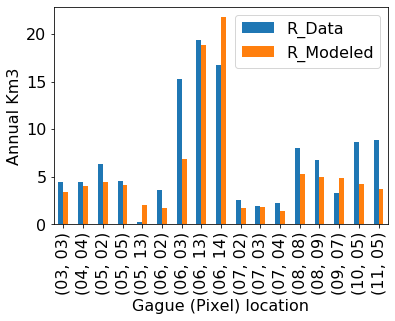

In [70]:
res = ToDF(runval.misfitR)
dat = ToDF(runval.R_Data)
mod = ToDF(runval.R_Modeled)

#Discharge Guages
df1 = dat.groupby(['r','c']).sum()
df2 = mod.groupby(['r','c']).sum()
df3 = df1.join(df2)
df3.plot(kind='bar')
plt.ylabel('Annual Km3')
plt.xlabel('Gague (Pixel) location')

Including all the gauges seemed to help the basin outflow (at '06','14') but several locations are not very close matches. This is expected since the flow of water model is pixel to pixel and ignores the large canal projects. That some not at the basin end match, is perhaps a good sign.

# Additional Checks

## <font color='black'> ET and Crop Area </font>

/Users/Anjuli/anaconda3/lib/python3.7/site-packages/gdx/__init__.py:136: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  super(File, self).set_coords(name, inplace=True)


saved in /Users/Anjuli/GitHub/DAS_Tests/Figures/OutputFigures/R_


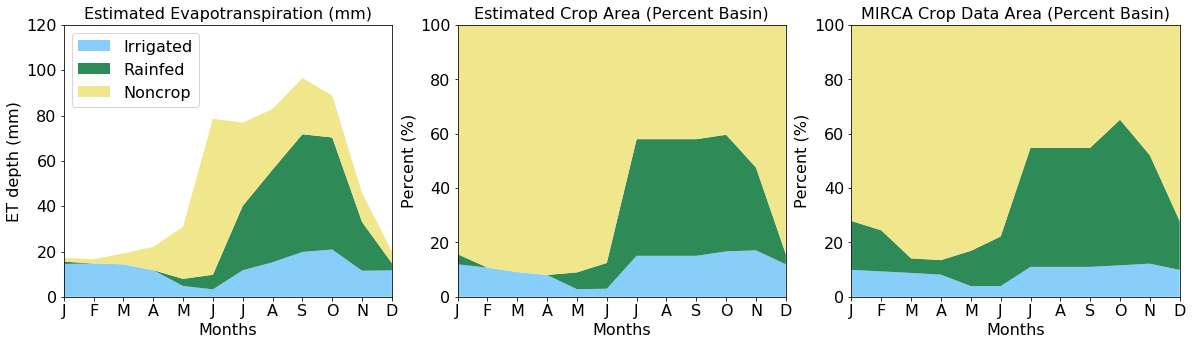

In [71]:
input_data = gdx.File(path+"/"+'inputs.gdx')

ira_data= monthsort(ToDF(input_data.CA_Data[:,:,:,0,:]).groupby(level=['time']).sum(),0) #thousand m2
rfa_data= monthsort(ToDF(input_data.CA_Data[:,:,:,1,:]).groupby(level=['time']).sum(),0)
ira_data.columns=['ira']
rfa_data.columns=['rfa']
CA_dat = ira_data.join(rfa_data) # km2

croplandET(runval, CA_dat, savepath)

It's not bad but I had been able to get better fits. The main concern is the overestimate of irrigated area.

## <font color='black'> ET by Crop </font>

saved in /Users/Anjuli/GitHub/DAS_Tests/Figures/OutputFigures/R_


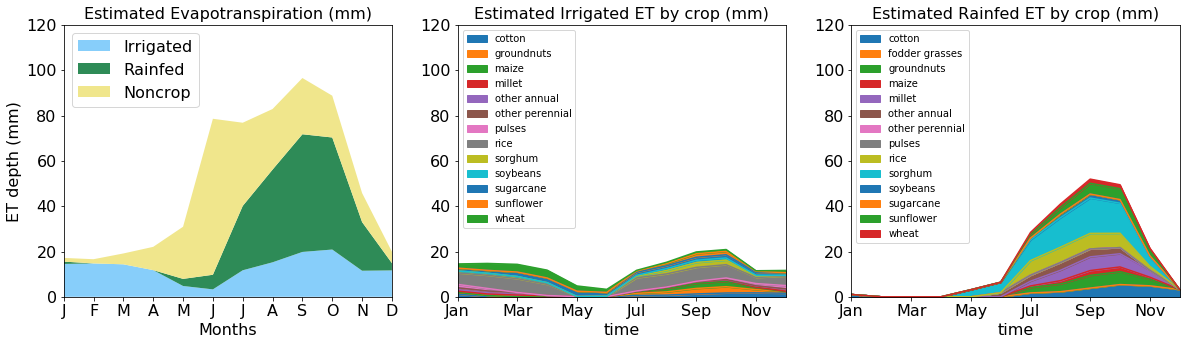

In [72]:
ETbyCrop(runval,CA_dat, savepath)

## <font color='black'> Yield </font>

saved in Figures/OutputFigures/Yield_


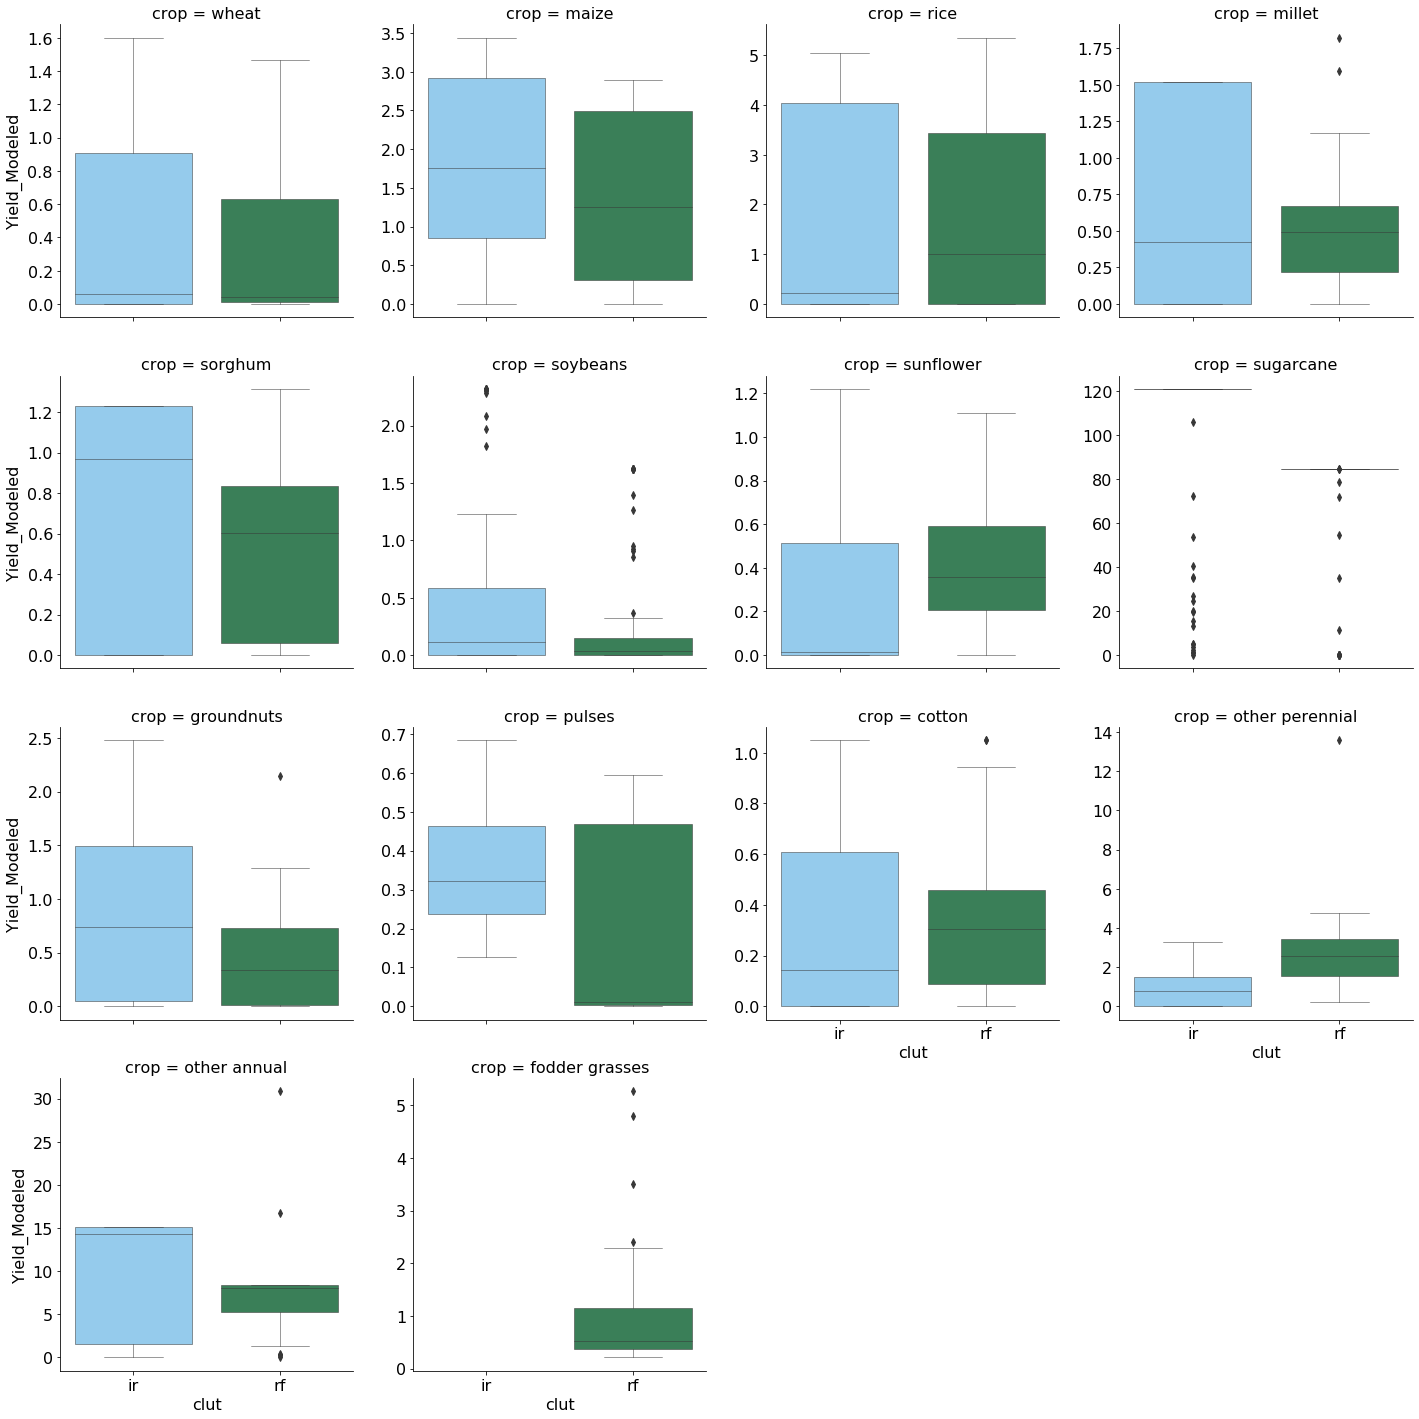

In [73]:
savepath = 'Figures/OutputFigures/Yield_'

YM = ToDF(runval.Yield_Modeled) #tons per 
YM.reset_index(inplace=True)

YM['crop']=YM['subcrop'].map(lambda x: str(x)[:-4])
YM['crop'].replace(MIRCA2000_cropclassesStr2, inplace=True)

import seaborn as sns
#f.fig.set_size_inches(8, 4)
f= sns.catplot(x="clut", y="Yield_Modeled", col='crop', col_wrap=4,
                  data=YM, legend=True, palette=sns.color_palette(['lightskyblue','seagreen']),
                  linewidth=0.5, kind='box', sharey=False)




plt.savefig(savepath+'yield_distribution_box.png', format='png', dpi=1200)
print('saved in '+savepath)   

plt.show()

I was hoping the irrigated would generally have a mean higher than rainfed and smaller range, or at least smaller low value. It happens only with some crops. Sugarcane yields went up to their max to try to keep up with the production values. These yields are within the observed range of 60-120 tons/ha for sugarcane.

## <font color='black'>Water Balance </font>

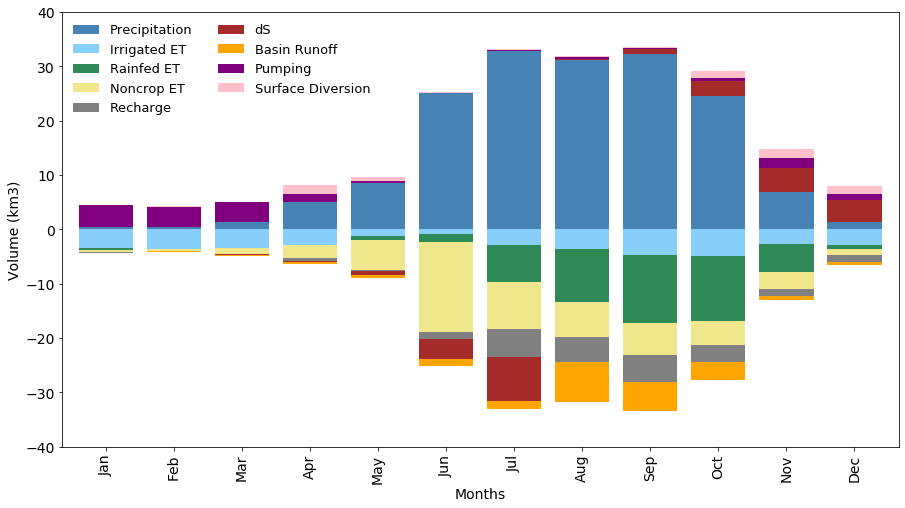

In [76]:
df = plotWaterBalance(runval)

# Convergence of St Deviation and Mean

GAMS was run over 50 times. Below is a graph of the mean approaching zero with the different tests and the standard deviation converging with the different tests. Some variables only appear after the 20+ run when I decided to separate some of the variables (for example separating Crop Area into Irrigated and Rainfed)

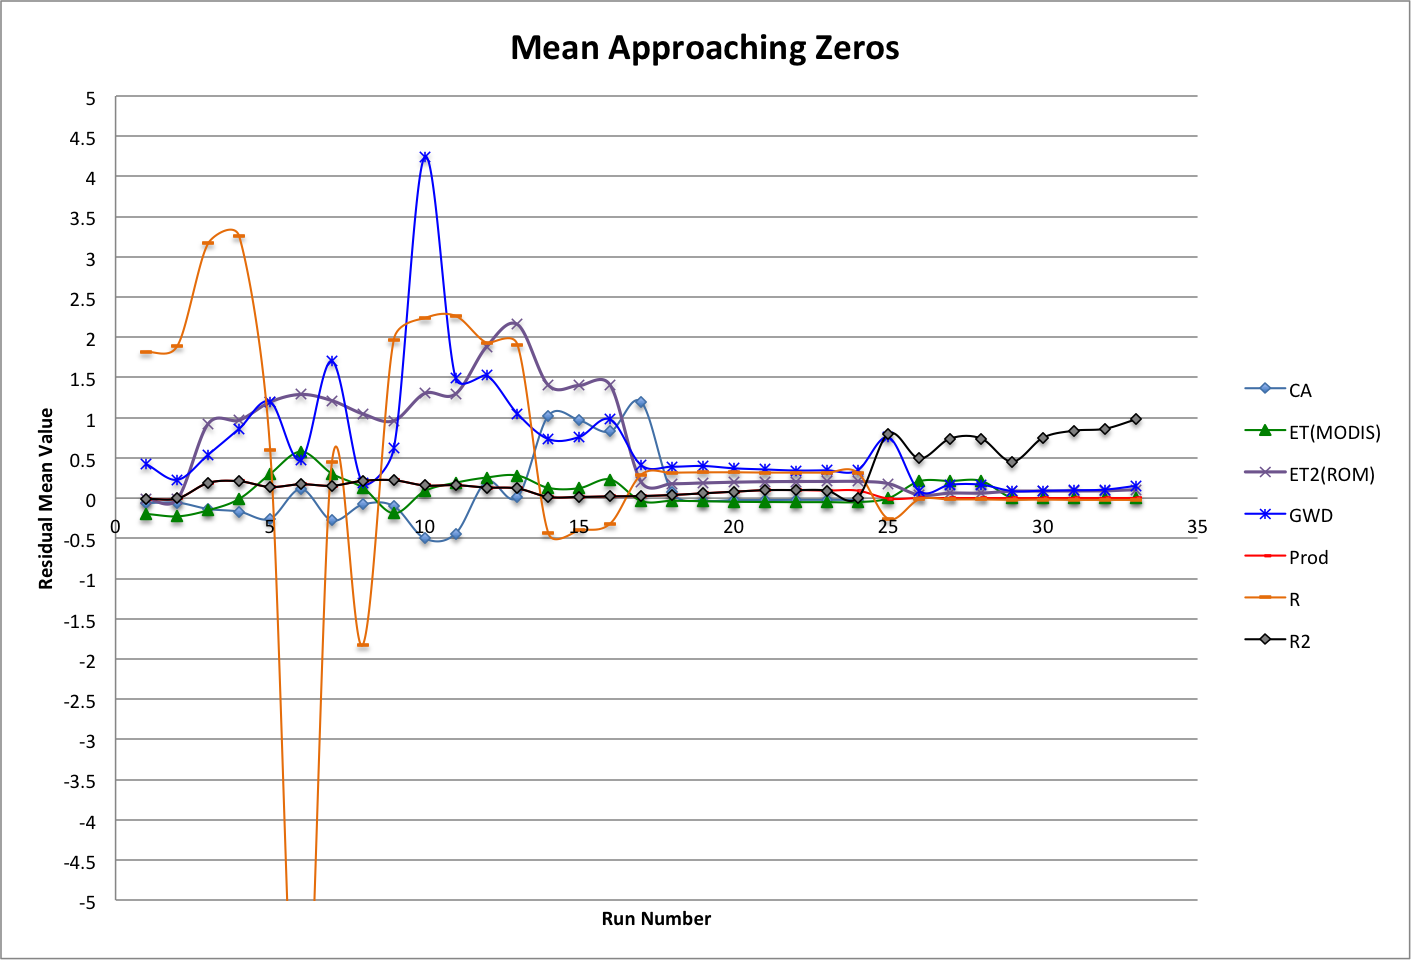

In [77]:
from IPython.display import Image
Image(filename="Figures/MeanConvergence2.png", height=100, width=800)

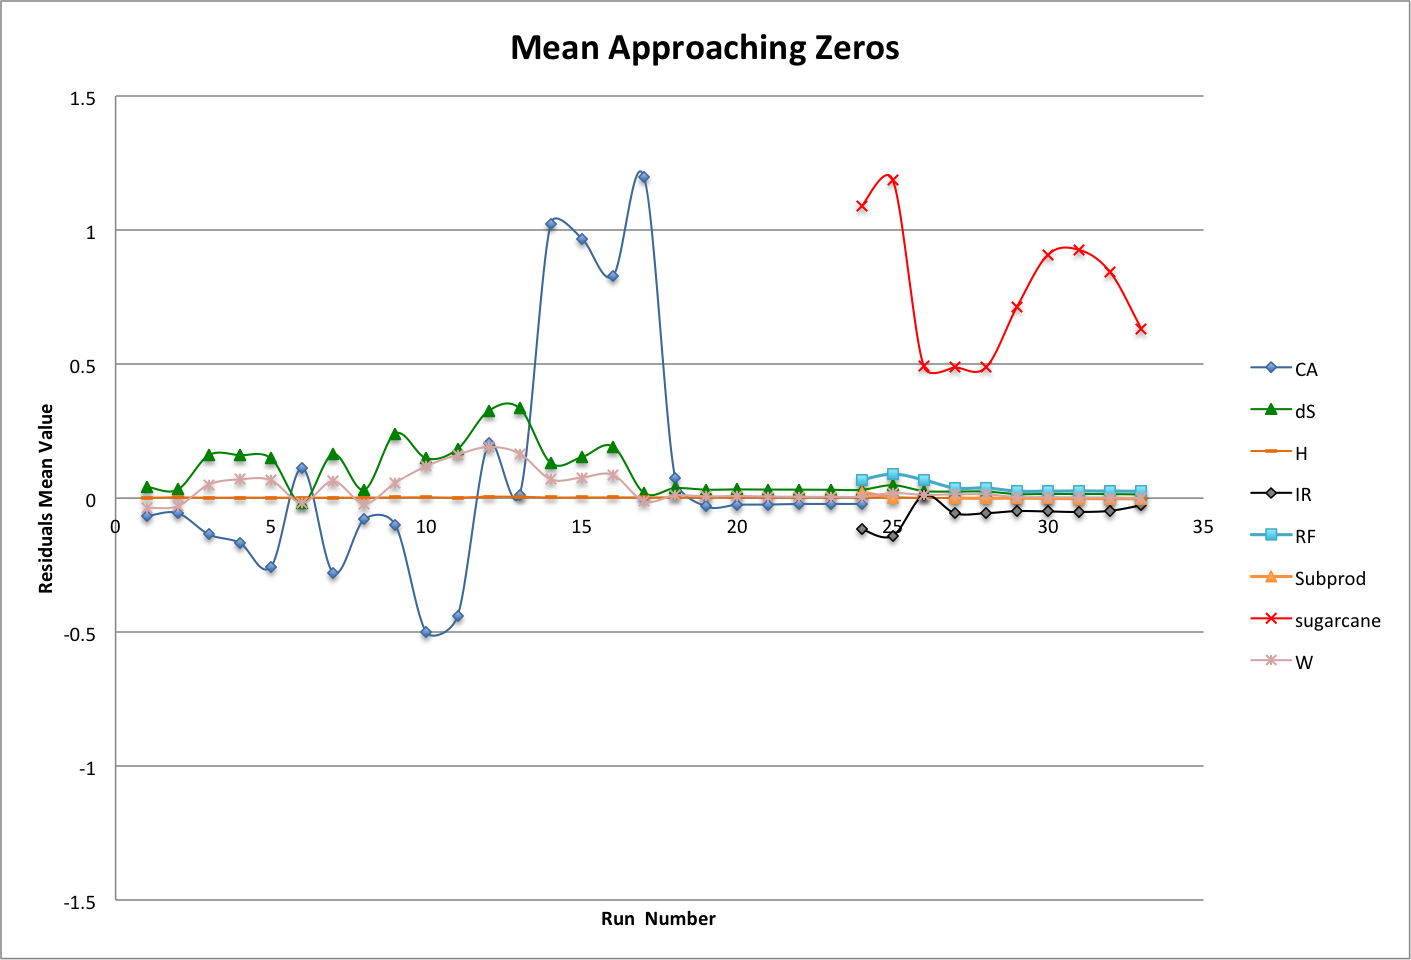

In [78]:
from IPython.display import Image
Image(filename="Figures/MeanConvergence1.png", height=100, width=800)

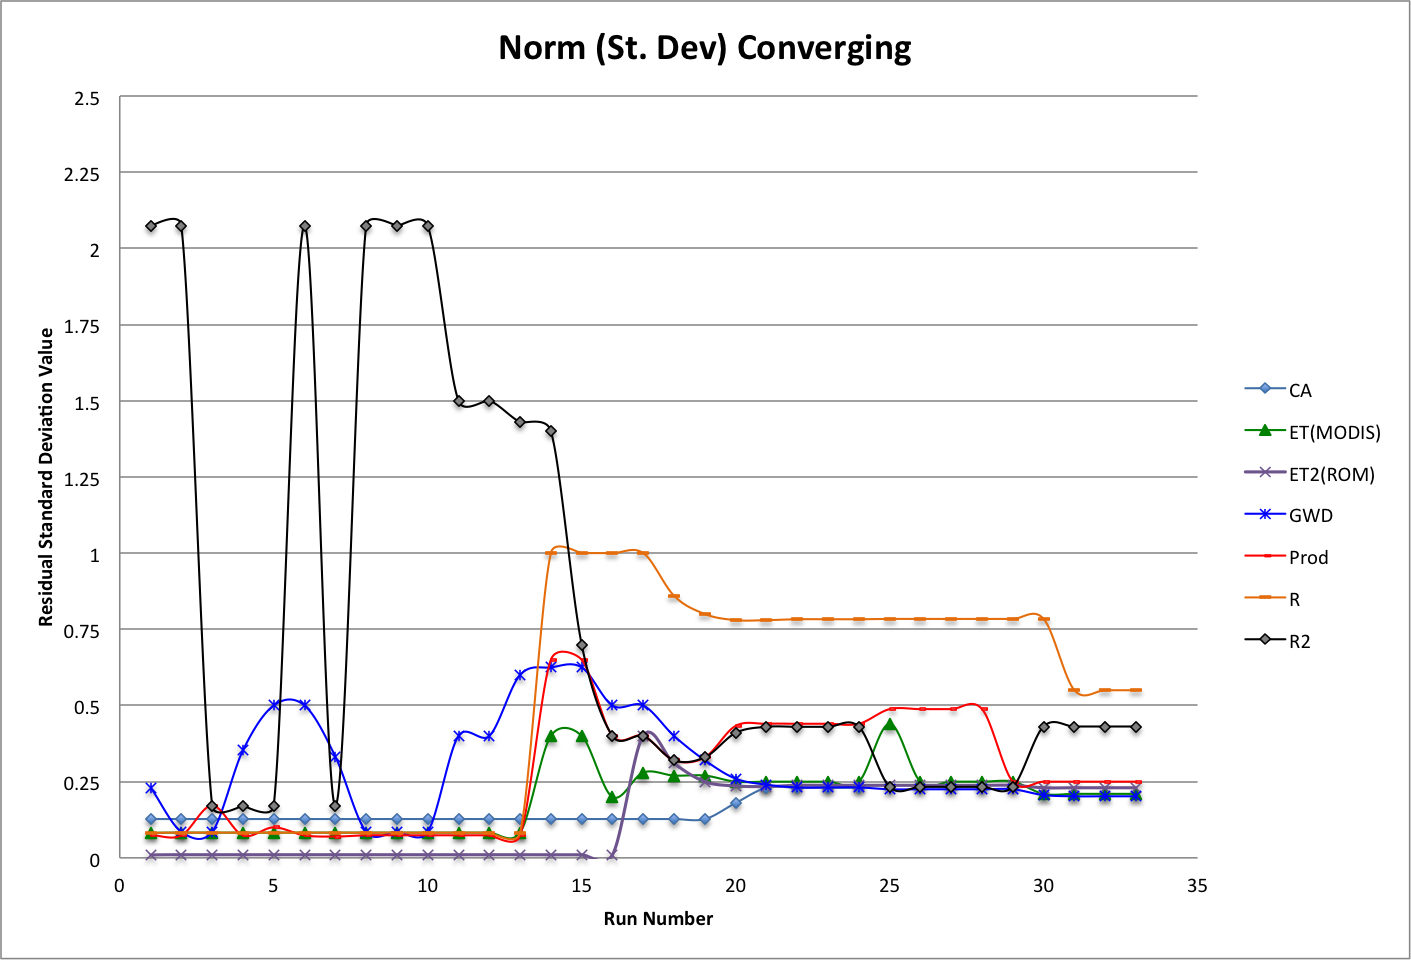

In [79]:
from IPython.display import Image
Image(filename="Figures/NormConvergence1.png", height=100, width=800)

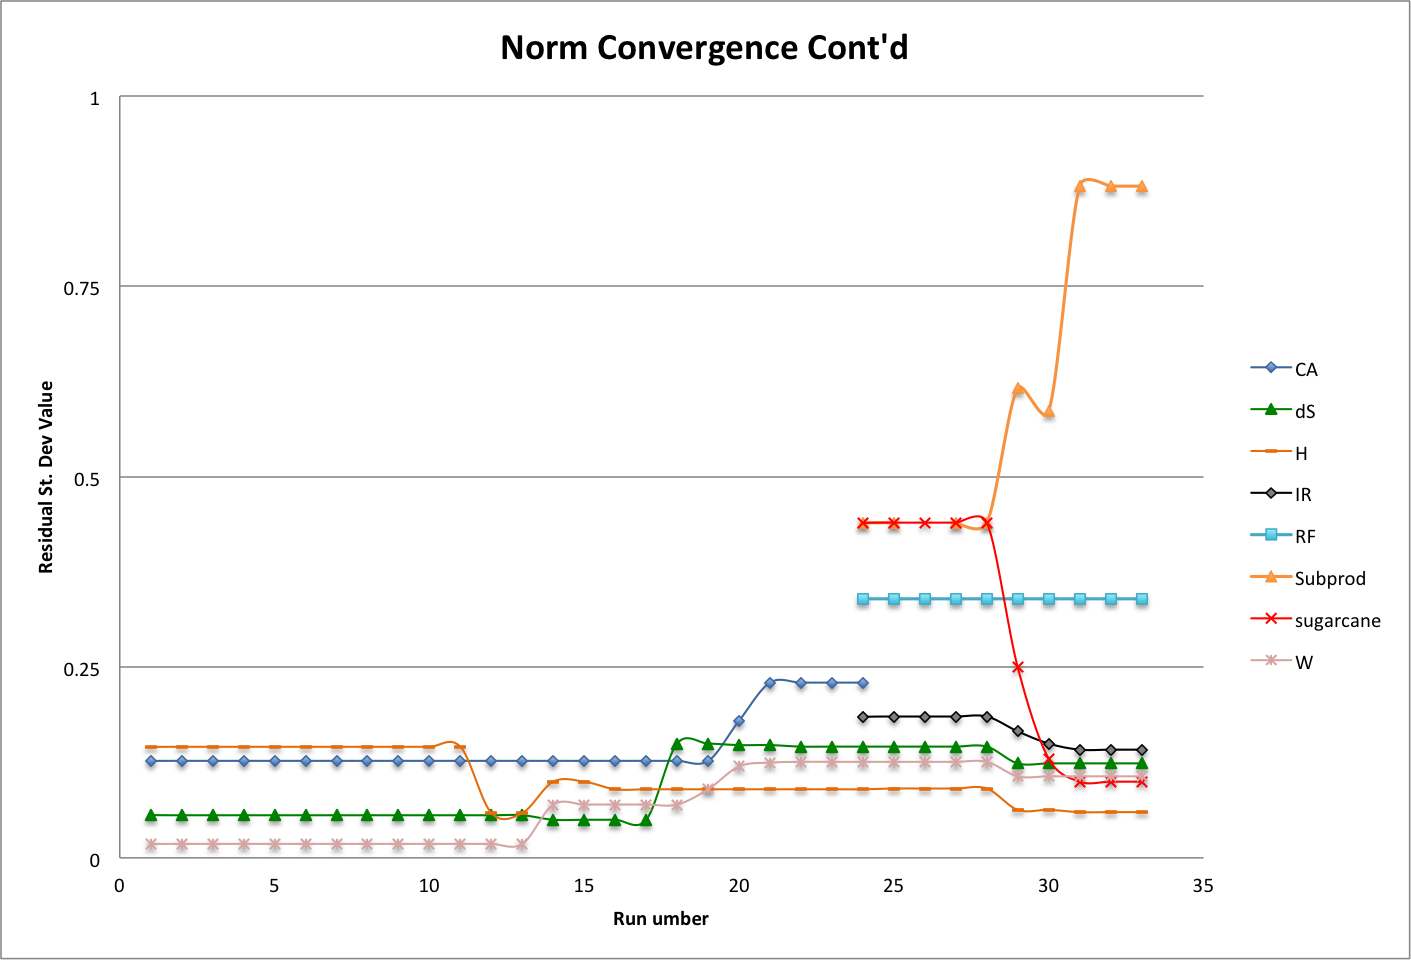

In [80]:
from IPython.display import Image
Image(filename="Figures/NormConvergence2.png", height=100, width=800)